# Introduction
Customer churn is a key business concept that determines the number of customers that stop doing business with a specific company. 

Predicting customer churn is critical for telecommunication companies to be able to effectively retain customers. It is more costly to acquire new customers than to retain existing ones. For this reason, large telecommunications corporations are seeking to develop models to predict which customers are more likely to change and take actions accordingly.

In this notebook, we build a model to predict how likely a customer will churn by analyzing its characteristics: (1) demographic information, (2) account information, and (3) services information. The objective is to obtain a data-driven solution that will allow us to reduce churn rates and, as a consequence, to increase customer satisfaction and corporation revenue.

## Initialization

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.metrics import roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import clone
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

## Pre-proccesing 

In [2]:
# Load the data files into different DataFrames
try:
    contract = pd.read_csv('/contract.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')

try:
    personal = pd.read_csv('/personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    
try:
    internet = pd.read_csv('/internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    
try:
    phone = pd.read_csv('/phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Contract Dataset

In [3]:
contract.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [4]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Conclusion**
* Change date related columns Dtype to date.
* Calculate period of contract.
* Add a column for churn based on the EndDate - Target for the project.
* MonthlyCharges Dtype shuld be a float.

In [6]:
# Duplicate EndDate column to create the target column
contract['Churn'] = contract.loc[:, 'EndDate']
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01 00:00:00


In [7]:
# Change values to Yes and No
contract["Churn"] = contract["Churn"].apply(lambda x:'No' if x == 'No' else 'Yes')

#### Dates

In [8]:
# To find the total time of the contract we will change No values to the final date issued
contract['EndDate'].replace({"No": "2020-02-01 00:00:00"}, inplace=True)

In [9]:
# Change Dtype into datetime
contract['EndDate']= pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S',errors='coerce')

In [10]:
contract["EndDate"].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [11]:
# Change Dtype into date
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [12]:
from datetime import datetime

# difference between dates in timedelta
contract['delta'] = contract['EndDate'] - contract['BeginDate']

In [13]:
contract['delta'] = contract['delta'].dt.days

In [14]:
# Remove and EndDate
contract = contract.drop('EndDate', axis=1)

In [15]:
# Remove and BeginDate
contract = contract.drop('BeginDate', axis=1)

In [16]:
# Remove not needed characters 
contract['TotalCharges'] = contract['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

In [17]:
# Change Dtype to numeric
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

### Personal Dataset

In [18]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [19]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [20]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### Internet Dataset

In [21]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [22]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1208-DNHLN,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1208-DNHLN,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### Phone Dataset

In [25]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [26]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1208-DNHLN,No
freq,1,3390


In [27]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Conclusion**
* There are no missing values in the data sets.
* While assuming the contract and personal data sets hold data on the same customers, counting 7043 attributes, the internet and phone data sets are smaller with only 5517 and 6361 attributes.

### Merge Datasets

In [28]:
# Merge the data for contract, personal, internet, phone based on customerID  

from functools import reduce

data_frames = [contract, personal, internet, phone]
nan_value = 0

df_merge = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                                                on=['customerID'],
                                              how='outer'), 
                  data_frames)
df_merge.shape

(7043, 20)

In [29]:
df_merge.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,delta,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,No,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,No,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [30]:
df_merge = df_merge.drop('customerID', axis=1)

## EDA

### Missing Values

In [31]:
#Check for NAs
df_merge.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Churn                  0
delta                  0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [32]:
df_merge = df_merge.dropna(subset = ['TotalCharges'])

In [33]:
df_merge.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
delta                  0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64

In [34]:
df_merge['InternetService'].value_counts(normalize=True)

Fiber optic    0.561684
DSL            0.438316
Name: InternetService, dtype: float64

In [35]:
# Replace missing values, maintaing the same ratio
df_merge['InternetService'] = df_merge['InternetService'].fillna(pd.Series(np.random.choice(['Fiber optic', 'DSL'], 
                                                      p=[0.56, 0.44], size=len(df_merge))))

In [36]:
df_merge['OnlineSecurity'].value_counts(normalize=True)

No     0.634434
Yes    0.365566
Name: OnlineSecurity, dtype: float64

In [37]:
# Replace missing values, maintaing the same ratio
df_merge['OnlineSecurity'] = df_merge['OnlineSecurity'].fillna(pd.Series(np.random.choice(['No', 'Yes'], 
                                                      p=[0.63, 0.37], size=len(df_merge))))

In [38]:
df_merge['OnlineBackup'].value_counts(normalize=True)

No     0.560051
Yes    0.439949
Name: OnlineBackup, dtype: float64

In [39]:
# Replace missing values, maintaing the same ratio
df_merge['OnlineBackup'] = df_merge['OnlineBackup'].fillna(pd.Series(np.random.choice(['No', 'Yes'], 
                                                      p=[0.56, 0.44], size=len(df_merge))))

In [40]:
df_merge['DeviceProtection'].value_counts(normalize=True)

No     0.561321
Yes    0.438679
Name: DeviceProtection, dtype: float64

In [41]:
# Replace missing values, maintaing the same ratio
df_merge['DeviceProtection'] = df_merge['DeviceProtection'].fillna(pd.Series(np.random.choice(['No', 'Yes'], 
                                                      p=[0.56, 0.44], size=len(df_merge))))

In [42]:
df_merge['TechSupport'].value_counts(normalize=True)

No     0.629898
Yes    0.370102
Name: TechSupport, dtype: float64

In [43]:
# Replace missing values, maintaing the same ratio
df_merge['TechSupport'] = df_merge['TechSupport'].fillna(pd.Series(np.random.choice(['No', 'Yes'], 
                                                      p=[0.37, 0.63], size=len(df_merge))))

In [44]:
df_merge['StreamingTV'].value_counts(normalize=True)

No     0.509615
Yes    0.490385
Name: StreamingTV, dtype: float64

In [45]:
# Replace missing values, maintaing the same ratio
df_merge['StreamingTV'] = df_merge['StreamingTV'].fillna(pd.Series(np.random.choice(['No', 'Yes'], 
                                                      p=[0.51, 0.49], size=len(df_merge))))

In [46]:
df_merge['MultipleLines'].value_counts(normalize=True)

No     0.532903
Yes    0.467097
Name: MultipleLines, dtype: float64

In [47]:
# Replace missing values, maintaing the same ratio
df_merge['MultipleLines'] = df_merge['MultipleLines'].fillna(pd.Series(np.random.choice(['No', 'Yes'], 
                                                      p=[0.53, 0.47], size=len(df_merge))))

In [48]:
# Identifying variables
df_uniques = pd.DataFrame([[i, len(df_merge[i].unique())] for i in df_merge.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
Type,3
PaperlessBilling,2
PaymentMethod,4
MonthlyCharges,1584
TotalCharges,6530
Churn,2
delta,155
gender,2
SeniorCitizen,2


In [49]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['PaperlessBilling',
 'Churn',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents']

In [50]:
categorical_variables = list(df_uniques[(12 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['Type',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [51]:
[[i, list(df_merge[i].unique())] for i in categorical_variables]

[['Type', ['Month-to-month', 'One year', 'Two year']],
 ['PaymentMethod',
  ['Electronic check',
   'Mailed check',
   'Bank transfer (automatic)',
   'Credit card (automatic)']],
 ['InternetService', ['DSL', 'Fiber optic', nan]],
 ['OnlineSecurity', ['No', 'Yes', nan]],
 ['OnlineBackup', ['Yes', 'No', nan]],
 ['DeviceProtection', ['No', 'Yes', nan]],
 ['TechSupport', ['No', 'Yes', nan]],
 ['StreamingTV', ['No', 'Yes', nan]],
 ['StreamingMovies', ['No', 'Yes', nan]],
 ['MultipleLines', ['No', 'Yes', nan]]]

In [52]:
numeric_variables = list(set(df_merge.columns) - set(categorical_variables) - set(binary_variables))
numeric_variables

['TotalCharges', 'MonthlyCharges', 'delta']

array([[<AxesSubplot:title={'center':'TotalCharges'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>],
       [<AxesSubplot:title={'center':'delta'}>, <AxesSubplot:>]],
      dtype=object)

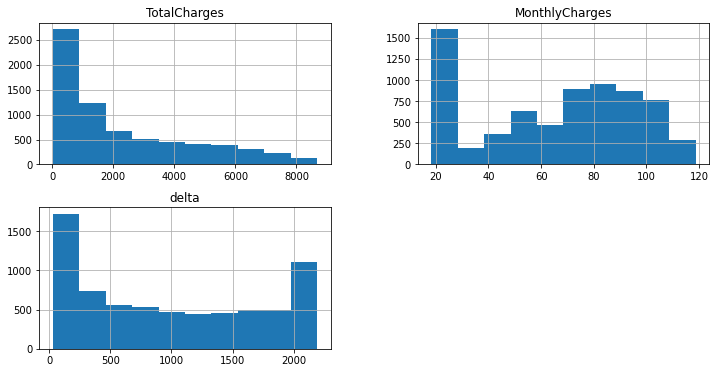

In [53]:
df_merge[numeric_variables].hist(figsize=(12, 6))

In [54]:
# Checking the distribution of contract type feature
df_merge['Type'].value_counts(normalize=True)

Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: Type, dtype: float64

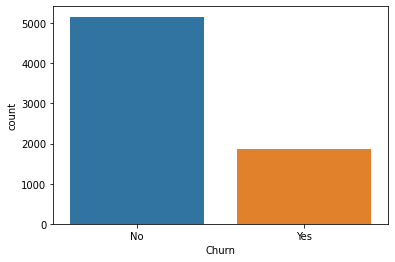

In [55]:
sns.countplot(x='Churn',data=df_merge)
plt.show()

In [56]:
df_merge['Churn'].value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

### OHE

In [57]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

In [58]:
# transforming categorical features into numerical features
data_ohe = pd.get_dummies(df_merge, drop_first=True)

In [59]:
lb, le = LabelBinarizer(), LabelEncoder()

In [60]:
for column in binary_variables:
    df_merge[column] = lb.fit_transform(df_merge[column])

In [61]:
df_merge = pd.get_dummies(df_merge, columns = categorical_variables, drop_first=True)

In [62]:
df_merge = pd.get_dummies(df_merge, columns = binary_variables, drop_first=True)

In [63]:
df_merge.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
delta,7032.0,987.538538,747.153663,30.00,275.0000,883.000,1676.0000,2191.00
Type_One year,7032.0,0.209329,0.406858,0.00,0.0000,0.000,0.0000,1.00
Type_Two year,7032.0,0.239619,0.426881,0.00,0.0000,0.000,0.0000,1.00
PaymentMethod_Credit card (automatic),7032.0,0.216297,0.411748,0.00,0.0000,0.000,0.0000,1.00
PaymentMethod_Electronic check,7032.0,0.336320,0.472483,0.00,0.0000,0.000,1.0000,1.00
PaymentMethod_Mailed check,7032.0,0.228100,0.419637,0.00,0.0000,0.000,0.0000,1.00
InternetService_Fiber optic,7032.0,0.566695,0.495567,0.00,0.0000,1.000,1.0000,1.00
OnlineSecurity_Yes,7032.0,0.364477,0.481317,0.00,0.0000,0.000,1.0000,1.00


In [64]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   delta                                  7032 non-null   int64  
 3   SeniorCitizen                          7032 non-null   int64  
 4   Type_One year                          7032 non-null   uint8  
 5   Type_Two year                          7032 non-null   uint8  
 6   PaperlessBilling_Yes                   7032 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 8   PaymentMethod_Electronic check         7032 non-null   uint8  
 9   PaymentMethod_Mailed check             7032 non-null   uint8  
 10  Churn_Yes                              7032 non-null   uint8  
 11  gend

### Target Class Imbalance

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


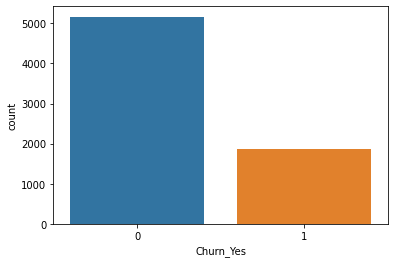

In [65]:
# visualize the target variable
target_distribution = sns.countplot(data_ohe['Churn_Yes'])
target_distribution.set_xticklabels(['0','1'])
plt.show()

In [66]:
# class count
class_count_0, class_count_1 = data_ohe['Churn_Yes'].value_counts()

# Separate class
class_0 = df_merge[data_ohe['Churn_Yes'] == 0]
class_1 = df_merge[data_ohe['Churn_Yes'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (5163, 22)
class 1: (1869, 22)


## Build a model

### Split the Data

In [67]:
from sklearn.model_selection import train_test_split

# Set up X and y variables
y, X = data_ohe['Churn_Yes'], data_ohe.drop(columns='Churn_Yes')

# Split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

### Metric For Evaluation

In [68]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Dummy Classifier

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier(random_state=42) 

pipe_dummy = Pipeline([('scaler', StandardScaler()), ('dummy', clf_dummy)])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe_dummy.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('dummy', clf_dummy)])
pipe_dummy.score(X_valid, y_valid)


0.7439544807965861

          train  test
Accuracy   0.73  0.74
F1         0.00  0.00
APS        0.27  0.26
ROC AUC    0.50  0.50
None


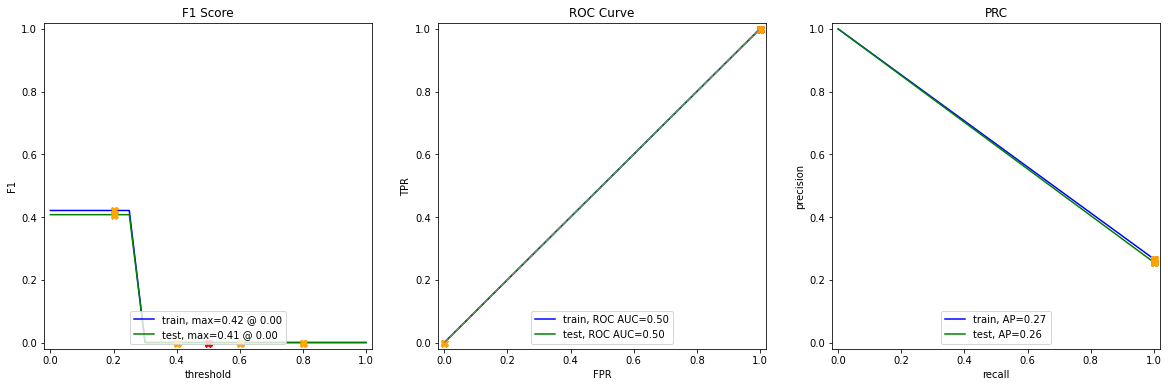

In [70]:
print(evaluate_model(clf_dummy, X_train, y_train, X_valid, y_valid))

## Decision Tree Classifier

In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=7)

pipe_dtc = Pipeline([('scaler', StandardScaler()), ('dtc', model_dtc)])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe_dtc.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('dtc', model_dtc)])
pipe_dtc.score(X_valid, y_valid)

0.8051209103840683

          train  test
Accuracy   0.84  0.81
F1         0.64  0.55
APS        0.77  0.66
ROC AUC    0.89  0.84
None


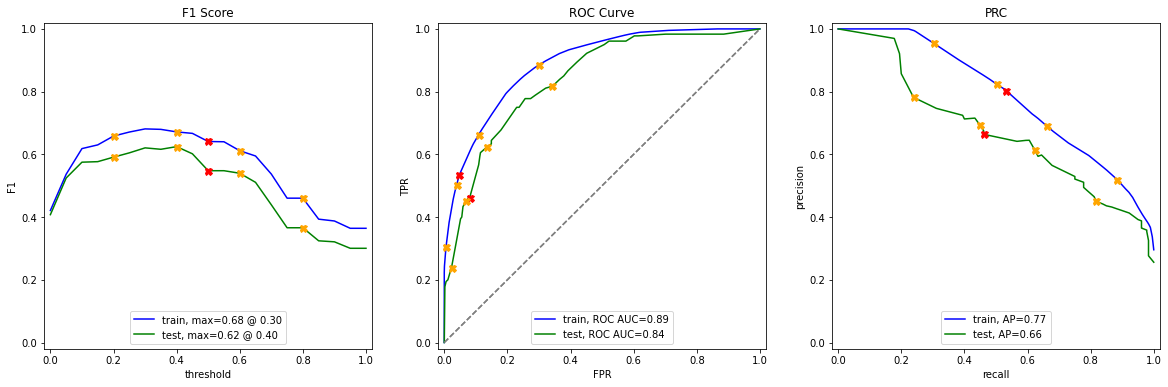

In [73]:
print(evaluate_model(pipe_dtc, X_train, y_train, X_valid, y_valid))

## Random Forest Classifier

### Grid Search and Hyper-parameter Tuning

In [74]:
# Inspect rf's hyperparameters

from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(random_state=54321, class_weight='balanced')
model_rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 54321,
 'verbose': 0,
 'warm_start': False}

In [75]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define a grid of hyperparameter 'params_nb'
params_rf = {
    'bootstrap': [True, False],
    'max_depth': [10, 60, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [20, 200, 500]
    }
# Instantiate 'grid_rf'
grid_rf = GridSearchCV(estimator=model_rfc,                       
                       param_grid=params_rf,                        
                       cv= 5,                       
                       verbose=1,                       
                       n_jobs=-1)

In [76]:
# Fit 'grid_nb' to the training set
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [ ]:
# Extract the best hyperparameters from 'grid_rf'
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

In [77]:
model_rfc = RandomForestClassifier(bootstrap = True, max_depth = 10, max_features = 'auto', min_samples_leaf= 4 ,min_samples_split = 2, n_estimators = 100)

pipe_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', model_rfc)])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe_rfc.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('rfc', model_rfc)])
pipe_rfc.score(X_valid, y_valid)

0.8122332859174964

          train  test
Accuracy   0.86  0.81
F1         0.69  0.57
APS        0.85  0.67
ROC AUC    0.94  0.86
None


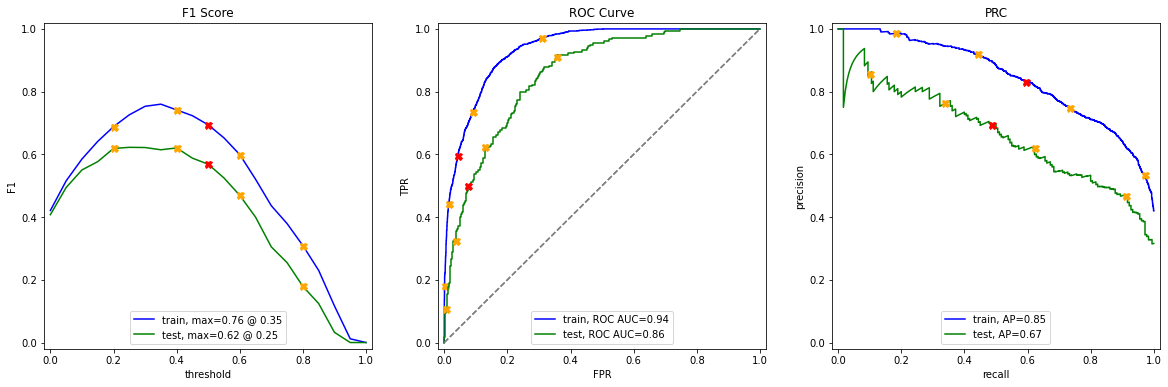

In [78]:
print(evaluate_model(pipe_rfc, X_train, y_train, X_valid, y_valid))

## KNN Classifier

### Best Number for KNN

In [79]:
### BEGIN SOLUTION
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

### BEGIN SOLUTION
max_k = 60
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_valid)
    f1 = f1_score(y_pred, y_valid)
    f1_scores.append((k, round(f1_score(y_valid, y_pred), 4)))
    error = 1-round(accuracy_score(y_valid, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

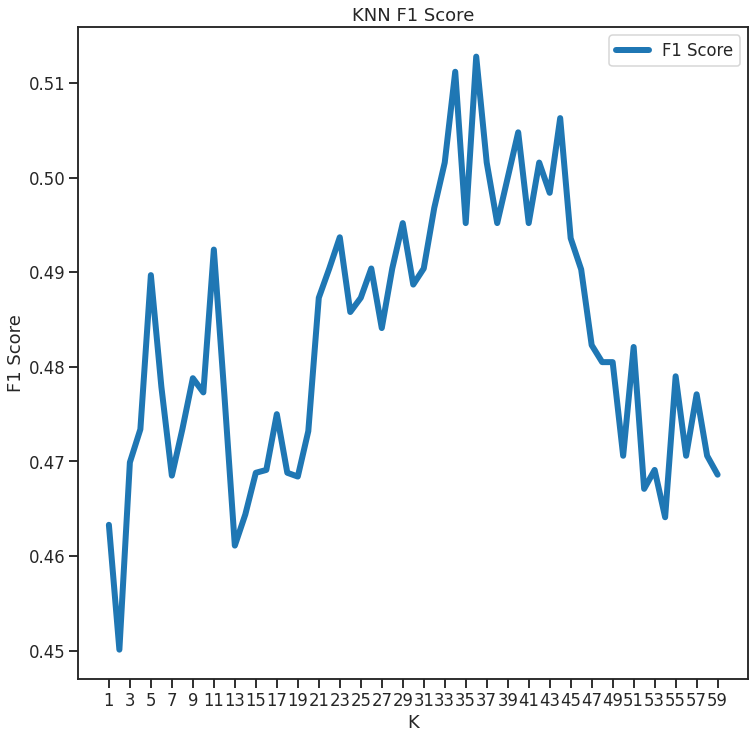

In [80]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

In [81]:
#Top three K
f1_results.sort_values(by='F1 Score', ascending=False).head(3)

,K,F1 Score
35,36,0.5128
33,34,0.5112
43,44,0.5063


In [92]:
# Estimate KNN model for k=20 and report outcomes
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=36)

pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', knn)])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe_knn.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('knnrfc', knn)])
pipe_knn.score(X_valid, y_valid)

0.7823613086770982

          train  test
Accuracy   0.80  0.78
F1         0.59  0.54
APS        0.65  0.57
ROC AUC    0.84  0.82
None


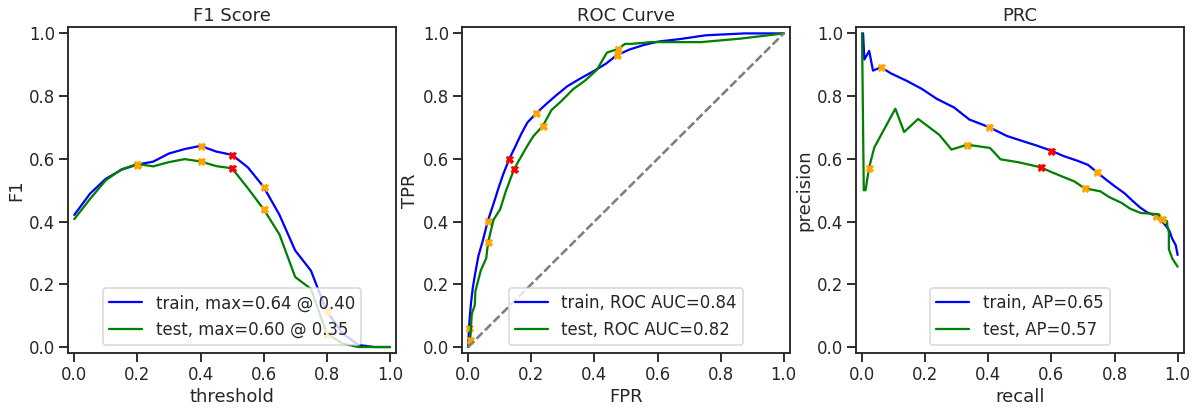

In [93]:
print(evaluate_model(pipe_knn, X_train, y_train, X_valid, y_valid))

F1 Score - This metric was chosen due for taking into account not only how many customers were rightly predicted, but also the overall quality of the predicition.
We will also examine ROC-AUC for project evaluation.

## Neural Network

In [84]:
# import tensorflow
import tensorflow as tf
#import keras 
from tensorflow import keras

In [85]:
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [86]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [87]:
for column in [numeric_variables]:
    df_merge[column] = mm.fit_transform(df_merge[column])

In [88]:
# define sequential model
model = keras.Sequential([
    # input layer
#    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8,activation = 'relu'),
    # we use sigmoid for binary output
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
]
)

2022-10-05 21:42:30.288262: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
# time for compilation of neural net.
optimizer = Adam(lr=0.05)
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = [keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)])
# now we fit our model to training data
model.fit(X_train,y_train,epochs=100)

Epoch 1/100
176/176 [==============================] - 1s 1ms/step - loss: 4.7724 - auc: 0.6607
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 1.1137 - auc: 0.7233
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 0.8123 - auc: 0.7358
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6410 - auc: 0.7655
Epoch 5/100
176/176 [==============================] - 0s 1ms/step - loss: 1.0973 - auc: 0.7176
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 0.7489 - auc: 0.7486
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 0.8419 - auc: 0.7400
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6912 - auc: 0.7619
Epoch 9/100
176/176 [==============================] - 0s 2ms/step - loss: 0.7522 - auc: 0.7506
Epoch 10/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6343 - auc: 0.7682
Epoch 11/100
176/176 [=================

In [90]:
# evalute the model
model.evaluate(
    x=X_valid,
    y=y_valid,
    batch_size=32,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False
)

[0.45662984251976013, 0.8140057325363159]

## Final Results

Dummy Classifier = 0.50<br>
Decision Tree Classifier = 0.84<br>
**Random Forest Classifier = 0.86**<br>
KNN Classifier = 0.82<br>
CNN Classifier = 0.81

          train  test
Accuracy   0.86  0.82
F1         0.69  0.61
APS        0.85  0.73
ROC AUC    0.94  0.86
None


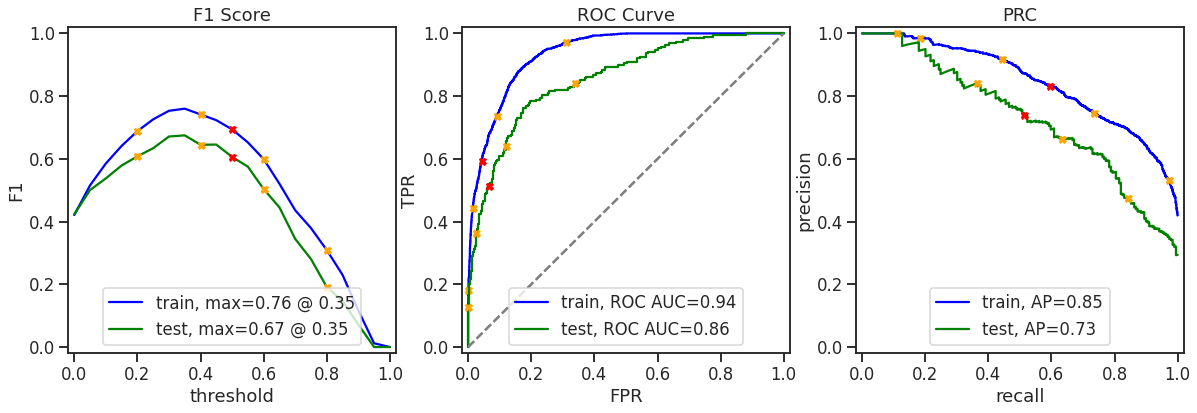

In [91]:
# Final evaluation using the test-set on the RF classifier
print(evaluate_model(pipe_rfc, X_train, y_train, X_test, y_test))

## Final Report

* Preparing the data was the first step in the project.<br>
Each column has been examined, the Dtypes have been modified, and the target column has been added.
* Afterwards, the data sets were merged and the columns were analyzed seperatly categorical and numerical.
* Using the OHE, we converted the values to 0 and 1 at the end of the exploratory data analysis.
* When the data was ready, it was split into a train and test set, and the first model was the dummy classifier.
* We divided the data into a test and train set, and started with a dummy classifier followed by a simple decision tree.
* Our third model was KNN, which was also analysed to determine which k number would yield the best results.
* The fourth model was a simple neural network based on Keras.
* With a ROC-AUC metric of 0.86, the results with the RF classifier were the most accurate.